# Analyse Statistique

### 1. Imports

In [1]:
# --------------------------------------------------------
# 0. Importations initiales
# --------------------------------------------------------
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
#import pingouin as pg  # <-- vous pouvez décommenter si vous voulez utiliser Pingouin
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Optionnel : configurations esthétiques
# plt.style.use('ggplot')   # par exemple, ou autre


## 1. Chargement et préparation des données

In [8]:
# Nom du dernier CSV
data_file = "SHS-Lie+detection+AI_May+28%2C+2025_08.23.csv" # "SHS-Lie+detection+AI_May+21%2C+2025_08.14.csv" #'SHS-Lie+detection+AI_May+12%2C+2025_09.03.csv' #"SHS-Lie+detection+AI_April+30%2C+2025_08.14.csv" # "SHS-Lie+detection+AI_April+9%2C+2025_11.22.csv"


df = pd.read_csv(data_file, header=0, skiprows=0)

# dictionnaire de correspondance pour les questions en français
questions = dict(zip(df.columns, df.iloc[0]))

# supprimer les 2 premières lignes (elles sont inutiles)
df = df[2:]

df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Education,Education.1,Origins,Q17,Q18,Q19,Q20,Q21,id,Source
2,2025-03-04 13:08:42,2025-03-04 13:15:49,1,NaN,100,427,1,2025-03-04 13:15:50,R_8KoMYiS7pLDRnTb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-12 02:34:38,2025-03-12 02:35:28,1,NaN,100,50,1,2025-03-12 02:35:28,R_8htFlTMqyNsXx6x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-13 10:59:26,2025-03-13 11:03:14,1,NaN,100,228,1,2025-03-13 11:03:15,R_89aiCGR6g3QzEOd,NaN,...,2,gegvr,bgrsbs,2,1,2,3,1,NaN,NaN
5,2025-03-14 01:09:01,2025-03-14 01:09:26,0,185.12.130.88,76,24,0,2025-03-14 01:12:01,R_2qBCQkuA3CFDdud,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025-04-02 04:07:37,2025-04-02 04:22:30,0,128.179.204.170,100,893,1,2025-04-02 04:22:31,R_8Do6YUFYQenUARY,NaN,...,5,Data science,France,5,5,"1,2,3,4,5,6,7,8,9,10",3,4,NaN,NaN


In [9]:
# df["Progress"]
(df["DistributionChannel"] == "anonymous").astype(int).sum()

np.int64(140)

In [10]:
len(df.loc[(df["Progress"].astype(int) > 75) | (df["Finished"].astype(int) != 0)])  

85

### Nettoyage / Filtrage

- Vérifier la cohérence des données.
- Supprimer ou identifier les valeurs manquantes ou aberrantes.
- Renommer les colonnes si nécessaire.


In [11]:
# garder seulement les questionnaires finis (à changer si trop peu de données)
df['Finished'] = df['Finished'].astype(int)
df = df.loc[(df["Finished"] > 0) | (df["Progress"].astype(int) > 95)] 
# df = df.loc[(df["Progress"].astype(int) > 75) | (df["Finished"].astype(int) != 0)] # df.loc[df["Finished"]!=0]


# enlver les previews de test de notre part
df = df.loc[df["DistributionChannel"] == "anonymous"]

# supprimer les colones non pertinentes
df = df.drop(columns=["EndDate","Status","IPAddress","RecipientLastName","RecipientFirstName","RecipientEmail","ExternalReference","LocationLatitude","LocationLongitude"], axis=1)

# trouver si groupe texte ou audio, et mettre dans la colonne "subgroup"
df["feedback_type"]= df["conf. post 3 (t,NH)_1"].isna().apply(lambda x: "audio" if x else "text")

def convert_to_score(x):
    if pd.isna(x):
        return 0
    else:
        return len([int(i) for i in x.split(",")])/10

df["technical_score"] = (df["Q18"].astype(float)/5+ df["Q19"].apply(convert_to_score) + df["Q20"].astype(float)/4)/3
df["familiaritiy_score"] = (df["Q17"].astype(float)+ df["Q21"].astype(float))/10

df.head()

,StartDate,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Consentement,Timer Video 1_First Click,...,Q17,Q18,Q19,Q20,Q21,id,Source,feedback_type,technical_score,familiaritiy_score
6,2025-04-02 04:07:37,100,893,1,2025-04-02 04:22:31,R_8Do6YUFYQenUARY,anonymous,FR,1,1.785,...,5,5,"1,2,3,4,5,6,7,8,9,10",3,4,NaN,NaN,audio,0.916667,0.9
7,2025-04-02 04:50:45,100,945,1,2025-04-02 05:06:30,R_3to1h0SPRWKMjoP,anonymous,FR,1,3.02,...,3,2,"1,2,3,4,5,6,7,8,9,10",2,3,NaN,NaN,audio,0.633333,0.6
8,2025-04-02 04:56:20,100,822,1,2025-04-02 05:10:03,R_7YEYfnqKlBiEcLK,anonymous,FR,1,9.996,...,5,3,"1,2,3,4,5,6,7,8,10",1,3,NaN,NaN,audio,0.583333,0.8
9,2025-04-02 06:28:01,100,2466,1,2025-04-02 07:09:09,R_5NFkJM20zBo2Fhf,anonymous,FR,1,10.201,...,1,2,"2,3,5,7,8,9",1,3,NaN,NaN,text,0.416667,0.4
10,2025-04-02 08:57:57,100,1496,1,2025-04-02 09:22:54,R_80NvFqnRsqG3Ofm,anonymous,FR,1,7.873,...,2,2,"1,2,3,4",1,3,NaN,NaN,audio,0.350000,0.5


In [14]:
len(df)


78

### Renommer les colonnes en minuscules et standardiser l'écriture

In [15]:
import re

# Step 1: Standardize column names
# Convert all to lowercase
df.columns = [col.lower() for col in df.columns]

# Standardize column names
new_columns = {}
for col in df.columns:
    # Start with the original lowercase column
    new_col = col
    
    # Replace various spellings and accents
    new_col = new_col.replace('initale', 'initiale').replace('initialle', 'initiale')
    new_col = new_col.replace('vérité', 'verite')
    
    # Replace spaces with underscores
    new_col = new_col.replace(' ', '_').replace('.', '').replace('__', '_').replace('*','')
    
    # Store mapping
    new_columns[col] = new_col

# Rename the dataframe columns
df_new = df.rename(columns=new_columns)

## Création d'un nouveau dataframe avec une ligne par question.

In [16]:

# Initialize an empty list to store the restructured data
reshaped_data = []

#1oui2non

gt_guess_dict = {
    1: 2,
    2: 2,
    3: 2,
    4: 2,
    5: 1,
    6: 2,
    7: 1,
    8: 2,
    9: 1,
    10: 1}


feedb_guess_dict = {
    1: 2,
    2: 2,
    3: 2,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 2}


# Process each participant
for _, row in df_new.iterrows():
    participant_id = row['responseid']
    feedback_type = row['feedback_type'] if 'feedback_type' in row else None
    technical_score = row['technical_score'] if 'technical_score' in row else None
    familiarity_score = row['familiaritiy_score'] if 'familiaritiy_score' in row else None
    
    # Process each of the 10 videos
    for video_num in range(1, 11):
        # Extract time spent on the video
        timer_base = f'timer_video_{video_num}'
        time_submit = np.round(float(row.get(f'{timer_base}_last_click', np.nan))-float(row.get(f'{timer_base}_first_click', np.nan)),1)
        time_on_video = time_submit  # Or calculate a difference if needed
        
        # Extract the initial guess and confidence
        # initial_guess_base = f'verite_initiale_{video_num}'
        
        # initial_guess = None
        # for suffix in ['', '_l', '_t']:
        #     if f'{initial_guess_base}{suffix}' in row:
        #         initial_guess = row[f'{initial_guess_base}{suffix}']
        #         if initial_guess is not None:
        #             break
                
        initial_guess_base = f'verite_initiale_{video_num}'
        matching_columns = [col for col in row.index if col.startswith(initial_guess_base)]
        initial_guess = row[matching_columns[0]]
                
        # Get initial confidence
        initial_conf_base = f'conf_initiale_{video_num}'
        matching_columns = [col for col in row.index if col.startswith(initial_conf_base)]
        initial_confidence = row[matching_columns[0]]
        
        
        # Determine if feedback was given as human or AI
        # Based on video number: odd -> NH, even -> H
        hum_AI = "H" if video_num % 2 == 0 else "NH"
        
        # Extract the responses based on feedback type
        # Simplified to search for base patterns
        
        # Base patterns for text and audio feedback columns
        text_base =  f'verite_post_{video_num}_(t'
        text_conf_base = f'conf_post_{video_num}_(t'
        text_influence_base = f'influence_{video_num}_(t'
        text_comment_base = f'qo_{video_num}_(t'
        
        audio_base = f'verite_post_{video_num}_(a'
        audio_conf_base = f'conf_post_{video_num}_(a'
        audio_influence_base = f'influence_{video_num}_(a'
        audio_comment_base = f'qo_{video_num}_(a'
        
        # Choose which set of base patterns to use based on feedback_type
        if feedback_type == 'text':
            later_guess_base = text_base
            later_confidence_base = text_conf_base
            influence_base = text_influence_base
            comment_base = text_comment_base
        else:  # Assuming 'audio'
            later_guess_base = audio_base
            later_confidence_base = audio_conf_base
            influence_base = audio_influence_base
            comment_base = audio_comment_base
        
        # Extract values by matching the base pattern with any column containing it
        def get_value_by_base_pattern(bases, row):
            matching_cols = [col for col in row.index if col.startswith(bases)]
            if matching_cols[0]:
                return row[matching_cols[0]]
            return None
        
        later_guess = get_value_by_base_pattern(later_guess_base, row)
        later_confidence = get_value_by_base_pattern(later_confidence_base, row)
        feedback_influence = get_value_by_base_pattern(influence_base, row)
        comments = get_value_by_base_pattern(comment_base, row)
        
        # Create a dictionary for this video
        video_data = {
            'participant_id': participant_id,
            'video_number': video_num,
            'feedback_type': feedback_type,
            'hum_AI': hum_AI,  # Add the new column
            'time_on_video': time_on_video,
            'initial_guess': initial_guess,
            'initial_confidence': initial_confidence,
            'later_guess': later_guess,
            'later_confidence': later_confidence,
            'feedback_influence': feedback_influence,
            'comments': comments,
            'technical_score': technical_score,
            'familiarity_score': familiarity_score
        }
        
        # Add to our list
        reshaped_data.append(video_data)
        
# Create the new DataFrame
new_df = pd.DataFrame(reshaped_data)

# Save to CSV
new_df.to_csv('reshaped_lie_detection_data.csv', index=False)

new_df["feedback_change"] = new_df["initial_guess"] != new_df["later_guess"]
new_df["ground_truth"] = new_df["video_number"].map(gt_guess_dict)
new_df["AI_guess"] = new_df["video_number"].map(feedb_guess_dict)

# Remove rows with NaNs in the specified columns and reassign to new_df
new_df = new_df.dropna(subset=["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"])

# Convert the specified columns to integers
new_df[["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"]] = new_df[["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"]].astype(int)

new_df.head()

,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,technical_score,familiarity_score,feedback_change,ground_truth,AI_guess
0,R_8Do6YUFYQenUARY,1,audio,NH,33.9,1,87,1,54,1,NaN,0.916667,0.9,False,2,2
1,R_8Do6YUFYQenUARY,2,audio,H,56.8,2,68,1,69,1,NaN,0.916667,0.9,True,2,2
2,R_8Do6YUFYQenUARY,3,audio,NH,32.2,1,64,1,62,1,NaN,0.916667,0.9,False,2,2
3,R_8Do6YUFYQenUARY,4,audio,H,18.9,2,85,2,68,1,NaN,0.916667,0.9,False,2,1
4,R_8Do6YUFYQenUARY,5,audio,NH,20.7,1,77,1,91,1,NaN,0.916667,0.9,False,1,1


In [17]:
len(df)

78

### Effect of feedback source (AI vs Human) on truth judgment change :

Compare if intial_judgment == post_judgment by creating flip variable (=1 if change, 0 if no change, so just column feedbck_change in int format)\
Compute mean of change for each video, look for each participant and feedback how many videos there was a change of opinion\
participant_id	feedback_source	feedback_type	flip_rate\
P01	            AI	                audio	              0.6\
P01	            Human	            audio	              0.2\
Do ANOVA between AI Feedback and Human feedback x Audio and text feedback to see who is the most influencial

In [18]:
new_df['initial_confidence'] = pd.to_numeric(new_df['initial_confidence'], errors='coerce')
new_df['later_confidence'] = pd.to_numeric(new_df['later_confidence'], errors='coerce')
new_df.head(10)

,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,technical_score,familiarity_score,feedback_change,ground_truth,AI_guess
0,R_8Do6YUFYQenUARY,1,audio,NH,33.9,1,87,1,54,1,NaN,0.916667,0.9,False,2,2
1,R_8Do6YUFYQenUARY,2,audio,H,56.8,2,68,1,69,1,NaN,0.916667,0.9,True,2,2
2,R_8Do6YUFYQenUARY,3,audio,NH,32.2,1,64,1,62,1,NaN,0.916667,0.9,False,2,2
3,R_8Do6YUFYQenUARY,4,audio,H,18.9,2,85,2,68,1,NaN,0.916667,0.9,False,2,1
4,R_8Do6YUFYQenUARY,5,audio,NH,20.7,1,77,1,91,1,NaN,0.916667,0.9,False,1,1
5,R_8Do6YUFYQenUARY,6,audio,H,75.3,2,58,2,40,1,NaN,0.916667,0.9,False,2,1
6,R_8Do6YUFYQenUARY,7,audio,NH,23.1,1,74,1,87,1,NaN,0.916667,0.9,False,1,1
7,R_8Do6YUFYQenUARY,8,audio,H,24.2,1,88,1,93,1,NaN,0.916667,0.9,False,2,1
8,R_8Do6YUFYQenUARY,9,audio,NH,20.4,2,46,2,25,1,NaN,0.916667,0.9,False,1,1
9,R_8Do6YUFYQenUARY,10,audio,H,30.8,2,41,2,66,1,NaN,0.916667,0.9,False,1,2


In [19]:
import pingouin as pg

# Step 1: Create feedback_source and flip columns
new_df['feedback_source'] = new_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
new_df['flip'] = new_df['feedback_change'].astype(int)

# Step 2: Compute mean flip rate for each participant × source × type
flip_rates = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Step 3: Pivot to wide format
pivot_df = flip_rates.pivot(index=['participant_id', 'feedback_type'], 
                             columns='feedback_source', 
                             values='flip_rate').dropna().reset_index()
pivot_df.columns.name = None  # Remove index name from columns
pivot_df = pivot_df.rename(columns={'AI': 'flip_rate_ai', 'Human': 'flip_rate_human'})

# Step 4: Reshape to long format
anova_df = pd.melt(
    pivot_df,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['flip_rate_ai', 'flip_rate_human'],
    var_name='feedback_source',
    value_name='flip_rate'
)

# Step 5: Clean feedback_source column
anova_df['feedback_source'] = anova_df['feedback_source'].map({
    'flip_rate_ai': 'AI',
    'flip_rate_human': 'Human'
})

# Step 6: Run mixed ANOVA
anova_results = pg.mixed_anova(
    data=anova_df,
    dv='flip_rate',
    within='feedback_source',
    between='feedback_type',
    subject='participant_id'
)

print(anova_results)

            Source        SS  DF1  DF2        MS         F     p-unc  \
0    feedback_type  0.142952    1   76  0.142952  3.271764  0.074437   
1  feedback_source  0.036923    1   76  0.036923  0.998492  0.320847   
2      Interaction  0.032685    1   76  0.032685  0.883881  0.350119   

        np2  eps  
0  0.041273  NaN  
1  0.012968  1.0  
2  0.011496  NaN  


/var/folders/p_/nc1tw1g92q71vzkdf1mdpk680000gn/T/ipykernel_14538/3703932343.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


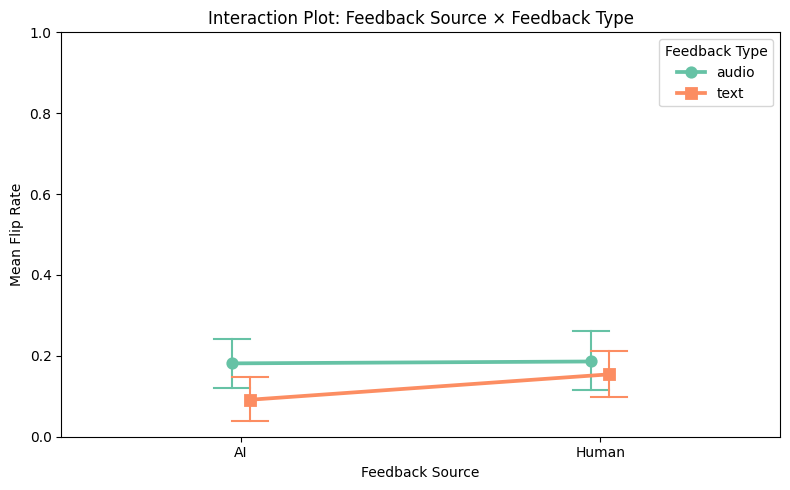

In [20]:
# Use the same long-format DataFrame (anova_df)
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=anova_df,
    x='feedback_source',
    y='flip_rate',
    hue='feedback_type',
    dodge=True,
    markers=['o', 's'],
    capsize=.1,
    errwidth=1.5,
    palette='Set2'
)

plt.title('Interaction Plot: Feedback Source × Feedback Type')
plt.ylabel('Mean Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(0, 1)
plt.legend(title='Feedback Type')
plt.tight_layout()
plt.show()

/var/folders/p_/nc1tw1g92q71vzkdf1mdpk680000gn/T/ipykernel_14538/2936908940.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


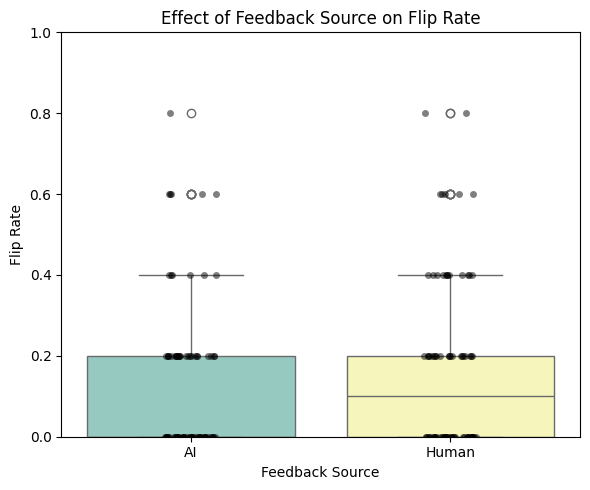

In [21]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=anova_df,
    x='feedback_source',
    y='flip_rate',
    palette='Set3'
)
sns.stripplot(
    data=anova_df,
    x='feedback_source',
    y='flip_rate',
    color='black',
    alpha=0.5,
    jitter=True
)

plt.title('Effect of Feedback Source on Flip Rate')
plt.ylabel('Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


/var/folders/p_/nc1tw1g92q71vzkdf1mdpk680000gn/T/ipykernel_14538/2106899325.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


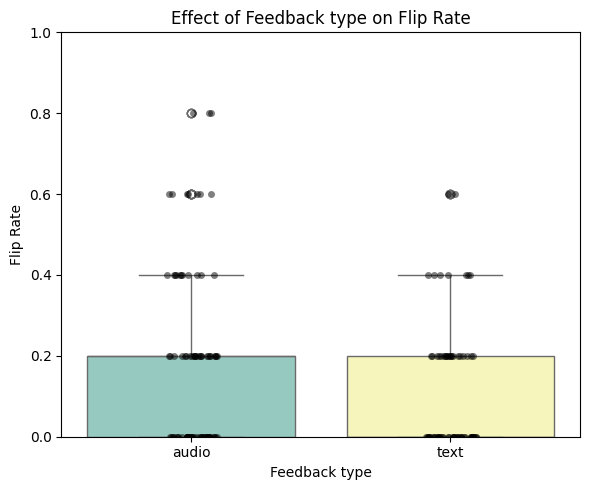

In [22]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=anova_df,
    x='feedback_type',
    y='flip_rate',
    palette='Set3'
)
sns.stripplot(
    data=anova_df,
    x='feedback_type',
    y='flip_rate',
    color='black',
    alpha=0.5,
    jitter=True
)

plt.title('Effect of Feedback type on Flip Rate')
plt.ylabel('Flip Rate')
plt.xlabel('Feedback type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Effect of feedback source on confidence change :
Compute confidence change (post - initial)\
participant_id	feedback_source	feedback_type	mean_conf_change\
P01	AI	audio	+15\
P01	Human	audio	+5\
ANOVA AI Feedback and Human feedback x Audio and text feedback

In [23]:
# Step 1: Create feedback_source and compute confidence_change
new_df['feedback_source'] = new_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
new_df['confidence_change'] = new_df['later_confidence'] - new_df['initial_confidence']

# Step 2: Compute mean confidence change per participant × source × type
conf_df = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

# Step 3: Prepare for mixed ANOVA
# Data should already be in long format: one row per participant × condition
anova_conf = pg.mixed_anova(
    data=conf_df,
    dv='mean_conf_change',
    within='feedback_source',
    between='feedback_type',
    subject='participant_id'
)

# Step 4: Print results
print(anova_conf)

            Source          SS  DF1  DF2          MS         F     p-unc  \
0    feedback_type  171.064992    1   76  171.064992  1.652695  0.202496   
1  feedback_source  168.646410    1   76  168.646410  2.131651  0.148407   
2      Interaction   12.562666    1   76   12.562666  0.158789  0.691391   

        np2  eps  
0  0.021283  NaN  
1  0.027283  1.0  
2  0.002085  NaN  


In [24]:
conf_df

,participant_id,feedback_source,feedback_type,mean_conf_change
0,R_1Ra6z3SyuebyqsE,AI,audio,-0.6
1,R_1Ra6z3SyuebyqsE,Human,audio,5.4
2,R_1eW39XhMxtmNOvv,AI,audio,-4.4
3,R_1eW39XhMxtmNOvv,Human,audio,-3.2
4,R_1egeBUaB0oERkjz,AI,audio,-1.2
...,...,...,...,...
151,R_8sWH8Oa8SRj0LXO,Human,text,5.8
152,R_8t9cMzAmLWPujmN,AI,text,6.0
153,R_8t9cMzAmLWPujmN,Human,text,-2.4
154,R_8wd1VXB6T4MEmSB,AI,audio,-26.8


/var/folders/p_/nc1tw1g92q71vzkdf1mdpk680000gn/T/ipykernel_14538/1972053640.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


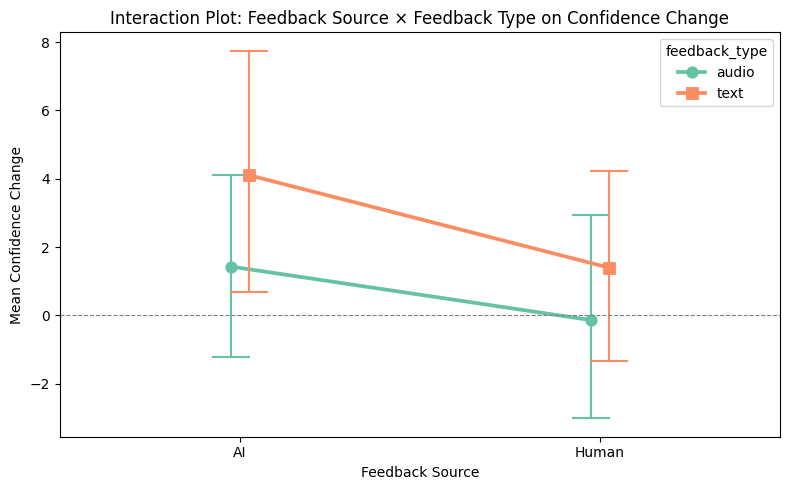

In [25]:
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=conf_df,
    x='feedback_source',
    y='mean_conf_change',
    hue='feedback_type',
    dodge=True,
    markers=['o', 's'],
    capsize=.1,
    errwidth=1.5,
    palette='Set2'
)

plt.title('Interaction Plot: Feedback Source × Feedback Type on Confidence Change')
plt.ylabel('Mean Confidence Change')
plt.xlabel('Feedback Source')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

/var/folders/p_/nc1tw1g92q71vzkdf1mdpk680000gn/T/ipykernel_14538/1052900631.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


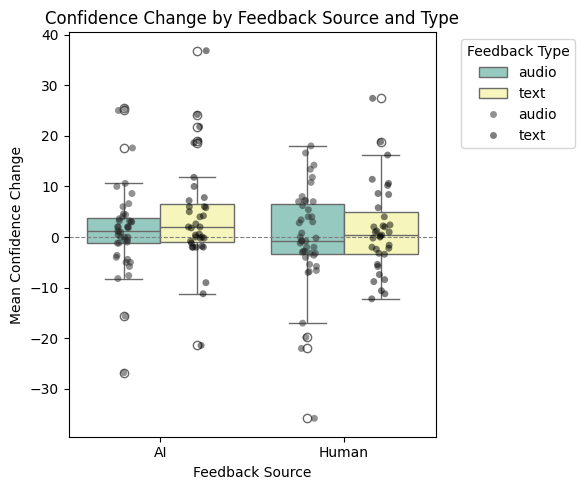

In [26]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=conf_df,
    x='feedback_source',
    y='mean_conf_change',
    hue='feedback_type',
    palette='Set3'
)
sns.stripplot(
    data=conf_df,
    x='feedback_source',
    y='mean_conf_change',
    hue='feedback_type',
    dodge=True,
    color='black',
    alpha=0.5,
    jitter=True
)

plt.title('Confidence Change by Feedback Source and Type')
plt.ylabel('Mean Confidence Change')
plt.xlabel('Feedback Source')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(title='Feedback Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### AI familiarity moderates effect of AI feedback : 
Take only AI feedbacks\
Mean Confidence or flip\
Pearson Correlation (to show how strongly two continuous variable are related with the direction too) between AI familiarity and flip (or linear regression)

participant_id	ai_familiarity	ai_flip_rate	ai_conf_change\
P01	5	0.60	+10\
P02	2	0.20	-3


<Axes: xlabel='mean_conf_change', ylabel='technical_score'>

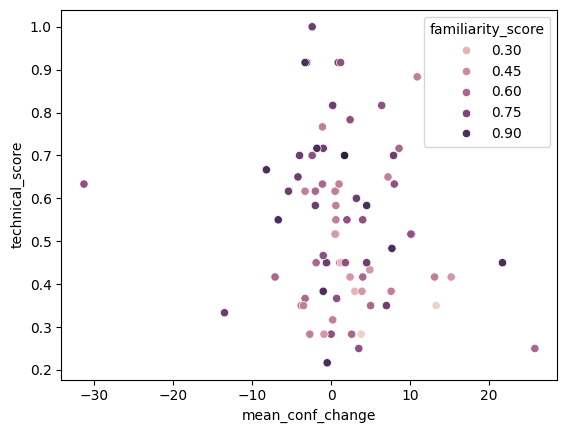

In [27]:
conf_df2 = (
    new_df
    .groupby(['participant_id', 'technical_score', 'familiarity_score'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

sns.scatterplot(
    x = "mean_conf_change",
    y = "technical_score",
    hue = "familiarity_score",
    data = conf_df2,
)

<Axes: xlabel='familiarity_score', ylabel='technical_score'>

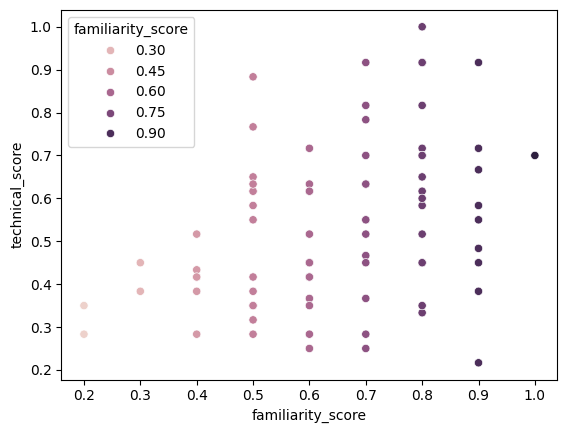

In [28]:

sns.scatterplot(
    x = "familiarity_score",
    y = "technical_score",
    hue = "familiarity_score",
    data = conf_df2,
)

In [29]:
# find the rows where the initial guess is not equal to the ai suggestion
df_AI_diff_feedback = new_df.loc[new_df["initial_guess"] != new_df["AI_guess"]]
df_AI_diff_feedback.loc[df_AI_diff_feedback["flip"]!=0].head()

,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,technical_score,familiarity_score,feedback_change,ground_truth,AI_guess,feedback_source,flip,confidence_change
29,R_7YEYfnqKlBiEcLK,10,audio,H,30.6,1,67,2,66,2,NaN,0.583333,0.8,True,1,2,Human,1,-1
30,R_5NFkJM20zBo2Fhf,1,text,NH,236.5,1,74,2,70,1,Ce qu’il y avait noté dans le feed-back,0.416667,0.4,True,2,2,AI,1,-4
37,R_5NFkJM20zBo2Fhf,8,text,H,151.1,2,56,1,0,1,Je détecte une description cohérente du tableau,0.416667,0.4,True,2,1,Human,1,-56
43,R_80NvFqnRsqG3Ofm,4,audio,H,82.2,2,45,1,50,1,Les arguments,0.350000,0.5,True,2,1,Human,1,5
49,R_80NvFqnRsqG3Ofm,10,audio,H,48.2,1,50,2,50,1,NaN,0.350000,0.5,True,1,2,Human,1,0


Cas ou l'IA donne un avis différent du inital guess, les gens avec les meilleurs scores techniques semblent changer un peu moins d'avis.

In [30]:
df_AI_diff_feedback.groupby("flip")["technical_score"].mean().head()

flip
0    0.542342
1    0.510333
Name: technical_score, dtype: float64

<Axes: xlabel='flip', ylabel='technical_score'>

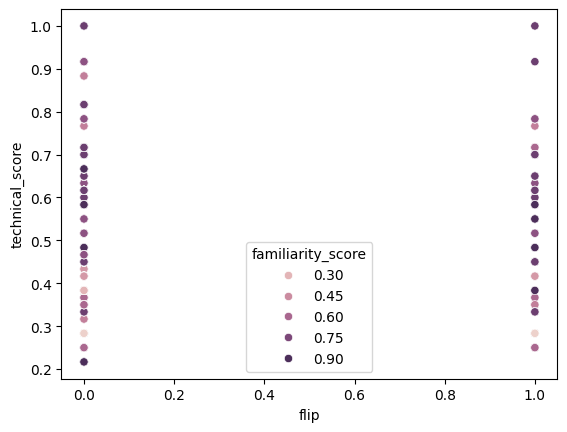

In [31]:
sns.scatterplot(
    x = "flip",
    y = "technical_score",
    hue = "familiarity_score",
    data = df_AI_diff_feedback,
)

In [32]:
# find the rows where the initial guess is the same as the ai suggestion
df_AI_same_feedback = new_df.loc[new_df["initial_guess"] == new_df["AI_guess"]]

<Axes: xlabel='mean_conf_change', ylabel='familiarity_score'>

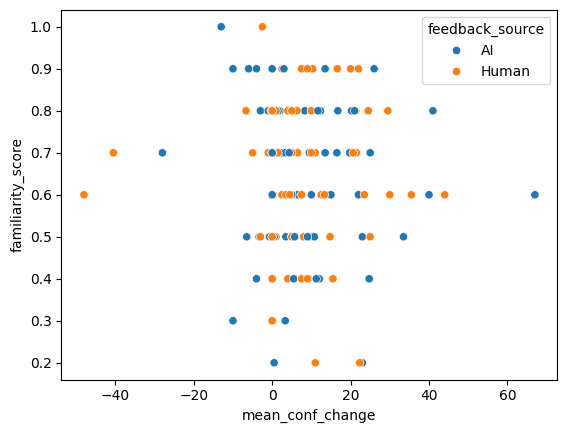

In [38]:
conf_df3 = (
    df_AI_same_feedback
    .groupby(['participant_id', 'technical_score', 'familiarity_score', "feedback_type", "feedback_source"])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

sns.scatterplot(
    x = "mean_conf_change",
    y = "familiarity_score",
    hue="feedback_source",

    data = conf_df3,
)

<Axes: xlabel='mean_conf_change', ylabel='technical_score'>

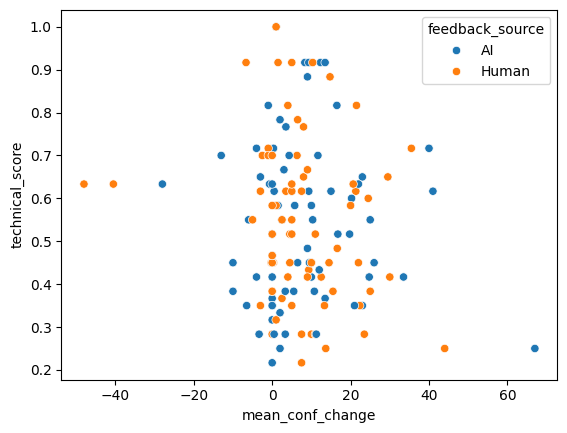

In [39]:
sns.scatterplot(
    x = "mean_conf_change",
    y = "technical_score",
    hue = "feedback_source",
    data = conf_df3,
)

In [40]:
new_df.head(20)

,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,technical_score,familiarity_score,feedback_change,ground_truth,AI_guess,feedback_source,flip,confidence_change
0,R_8Do6YUFYQenUARY,1,audio,NH,33.9,1,87,1,54,1,NaN,0.916667,0.9,False,2,2,AI,0,-33
1,R_8Do6YUFYQenUARY,2,audio,H,56.8,2,68,1,69,1,NaN,0.916667,0.9,True,2,2,Human,1,1
2,R_8Do6YUFYQenUARY,3,audio,NH,32.2,1,64,1,62,1,NaN,0.916667,0.9,False,2,2,AI,0,-2
3,R_8Do6YUFYQenUARY,4,audio,H,18.9,2,85,2,68,1,NaN,0.916667,0.9,False,2,1,Human,0,-17
4,R_8Do6YUFYQenUARY,5,audio,NH,20.7,1,77,1,91,1,NaN,0.916667,0.9,False,1,1,AI,0,14
5,R_8Do6YUFYQenUARY,6,audio,H,75.3,2,58,2,40,1,NaN,0.916667,0.9,False,2,1,Human,0,-18
6,R_8Do6YUFYQenUARY,7,audio,NH,23.1,1,74,1,87,1,NaN,0.916667,0.9,False,1,1,AI,0,13
7,R_8Do6YUFYQenUARY,8,audio,H,24.2,1,88,1,93,1,NaN,0.916667,0.9,False,2,1,Human,0,5
8,R_8Do6YUFYQenUARY,9,audio,NH,20.4,2,46,2,25,1,NaN,0.916667,0.9,False,1,1,AI,0,-21
9,R_8Do6YUFYQenUARY,10,audio,H,30.8,2,41,2,66,1,NaN,0.916667,0.9,False,1,2,Human,0,25


In [41]:
# Step 1: Compute flip rate per participant × feedback source
flip_summary = (
    new_df
    .groupby(['participant_id', 'feedback_source'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Step 2: Merge with conf_df3
conf_df3 = conf_df3.merge(
    flip_summary,
    on=['participant_id', 'feedback_source'],
    how='left'  # keep only rows from conf_df3
)

In [42]:
conf_df3.head(10)

,participant_id,technical_score,familiarity_score,feedback_type,feedback_source,mean_conf_change,flip_rate
0,R_1Ra6z3SyuebyqsE,0.783333,0.7,audio,AI,2.000000,0.6
1,R_1Ra6z3SyuebyqsE,0.783333,0.7,audio,Human,6.500000,0.0
2,R_1eW39XhMxtmNOvv,0.350000,0.5,audio,AI,-6.500000,0.2
3,R_1eW39XhMxtmNOvv,0.350000,0.5,audio,Human,-3.000000,0.2
4,R_1egeBUaB0oERkjz,0.483333,0.9,audio,AI,9.000000,0.4
5,R_1egeBUaB0oERkjz,0.483333,0.9,audio,Human,16.600000,0.2
6,R_1n91AdhujHNQUZF,0.250000,0.7,audio,AI,2.000000,0.2
7,R_1n91AdhujHNQUZF,0.250000,0.7,audio,Human,13.666667,0.4
8,R_21GwgasGE5hbaoY,0.716667,0.8,audio,AI,0.333333,0.0
9,R_21GwgasGE5hbaoY,0.716667,0.8,audio,Human,-1.000000,0.0


### Test whether AI familiarity predicts how much participants' confidence changes under AI feedback.

🔍 Pearson Correlation:
 r = -0.054, p = 0.643


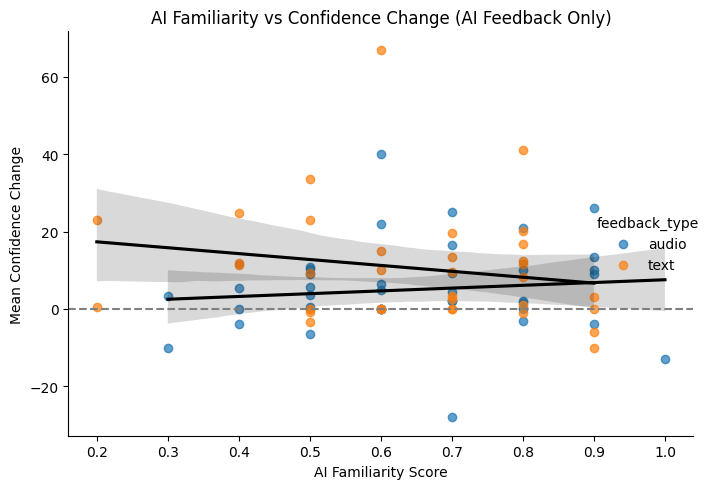

In [43]:
# Step 1: Filter only AI feedback
ai_only = conf_df3[conf_df3['feedback_source'] == 'AI'].copy()

# Step 2: Run Pearson correlation
r, p = pearsonr(ai_only['familiarity_score'], ai_only['mean_conf_change'])
print(f"🔍 Pearson Correlation:\n r = {r:.3f}, p = {p:.3f}")

# Step 3: Regression plot
sns.lmplot(
    data=ai_only,
    x='familiarity_score',
    y='mean_conf_change',
    hue='feedback_type',
    height=5,
    aspect=1.2,
    scatter_kws={'alpha': 0.7},
    line_kws={'color': 'black'}
)

plt.axhline(0, linestyle='--', color='gray')
plt.title("AI Familiarity vs Confidence Change (AI Feedback Only)")
plt.xlabel("AI Familiarity Score")
plt.ylabel("Mean Confidence Change")
plt.tight_layout()
plt.show()

AI familiarity does not appear to predict how much participants change their confidence under AI feedback.

The regression line is nearly flat.

Confidence intervals (gray area) are wide → high variability.

Data points are scattered with no clear trend — confidence change happens across all familiarity levels.



### Technical knowledge affects trust in AI vs human feedback : 
Take feedback source (AI or Human) and technical knowledge and mean flip/confidence\
Regression flip_rate ~ feedback_source * technical_knowledge

If the interaction is significant, it means technical knowledge influences the effect of the feedback source on flip rate

In [44]:
# Run the regression model with interaction
model = smf.ols('flip_rate ~ feedback_source * technical_score', data=conf_df3).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              flip_rate   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.2142
Date:                Wed, 28 May 2025   Prob (F-statistic):              0.886
Time:                        16:46:27   Log-Likelihood:                 33.893
No. Observations:                 148   AIC:                            -59.79
Df Residuals:                     144   BIC:                            -47.80
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

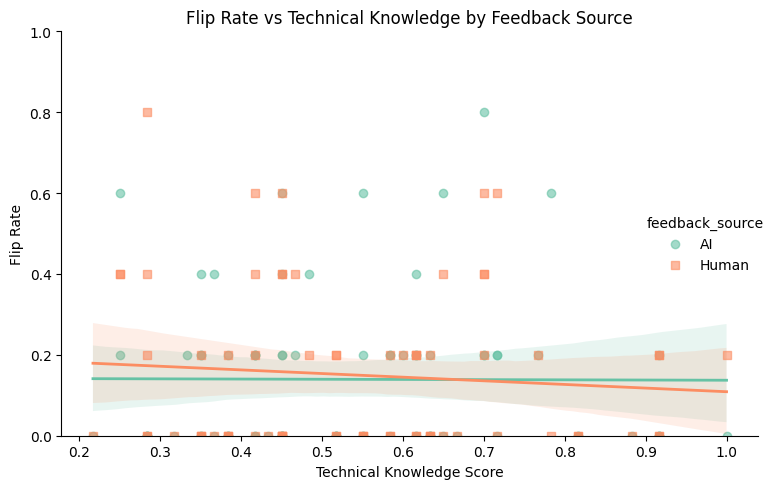

In [45]:
# Plot the regression lines
sns.lmplot(
    data=conf_df3,
    x='technical_score',
    y='flip_rate',
    hue='feedback_source',
    height=5,
    aspect=1.3,
    palette='Set2',
    markers=['o', 's'],
    scatter_kws={'alpha': 0.6},
    line_kws={'linewidth': 2}
)

plt.title("Flip Rate vs Technical Knowledge by Feedback Source")
plt.xlabel("Technical Knowledge Score")
plt.ylabel("Flip Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Tout est trop nul c'est fou...

The results do not support the idea that technical knowledge influences how much people trust or follow feedback from AI or Human sources.

None of the predictors are statistically significant (p > 0.05)

R² is almost zero → the model doesn’t explain much of the variability

Interaction is not significant → no moderation effect of technical skill

### Analyze open-ended responses
Count keyword frequencies 

/var/folders/p_/nc1tw1g92q71vzkdf1mdpk680000gn/T/ipykernel_14538/923215321.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_totals.values, y=word_totals.index, palette="rocket")


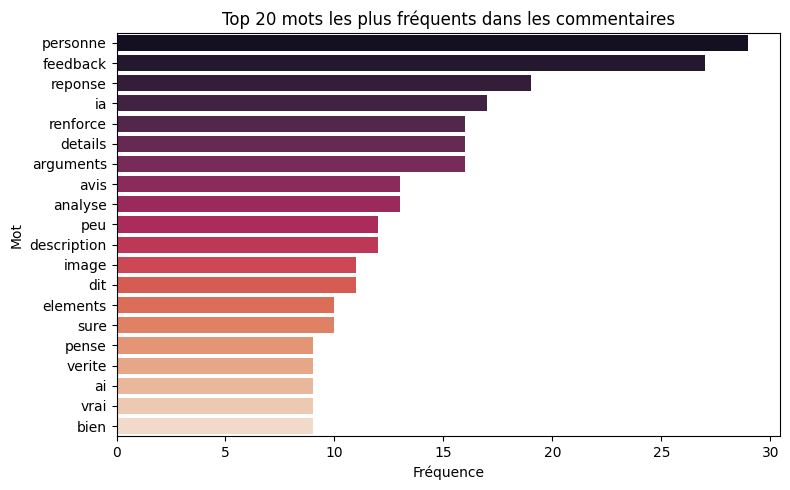

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
import unidecode

# Step 1: Extract and clean comments
comments = new_df['comments'].dropna().astype(str)

# Optional: normalize accents (é → e, etc.) for consistent counting
comments = comments.apply(lambda x: unidecode.unidecode(x.lower()))

# Step 2: Define a French stopword list
french_stopwords = [
    'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'ce', 'cet', 'cette',
    'et', 'ou', 'mais', 'donc', 'or', 'ni', 'car', 'je', 'tu', 'il', 'elle',
    'nous', 'vous', 'ils', 'elles', 'on', 'que', 'qui', 'quoi', 'dans',
    'ne', 'pas', 'plus', 'moins', 'comme', 'a', 'au', 'aux', 'avec', 'par',
    'pour', 'en', 'sur', 'sous', 'entre', 'chez', 'lui', 'leur', 'leurs',
    'y', 'se', 'sa', 'son', 'ses', 'ceci', 'cela', 'cette', 'quel', 'quelle',
    'quels', 'quelles', 'mes', 'tes', 'nos', 'vos', 'est', 'mon', 'qu', 'me', 
    'suis', 'ma', 'ca', 'tres', 'fait', 
]

# Step 3: Count word frequencies, excluding stopwords
vectorizer = CountVectorizer(stop_words=french_stopwords)
X = vectorizer.fit_transform(comments)

# Step 4: Summarize and visualize
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_totals = word_counts.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 5))
sns.barplot(x=word_totals.values, y=word_totals.index, palette="rocket")
plt.title('Top 20 mots les plus fréquents dans les commentaires')
plt.xlabel('Fréquence')
plt.ylabel('Mot')
plt.tight_layout()
plt.show()

<Axes: xlabel='feedback_influence', ylabel='Count'>

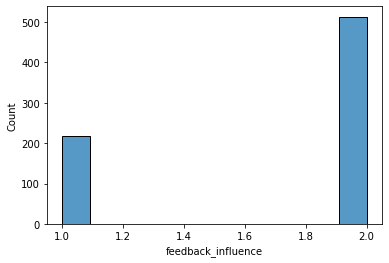

In [34]:
sns.histplot(data=new_df, x="feedback_influence")

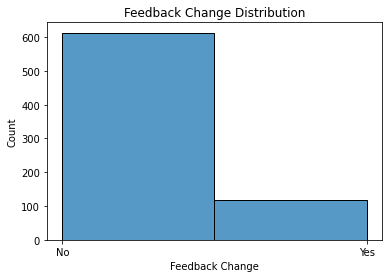

In [35]:
# plot the amount of people that changed their opions after feedback with only 2 bins and xticks no for 0 and yes for 1
sns.histplot(data=new_df, x="feedback_change",bins=2)
plt.xticks([0, 1], ["No", "Yes"])
plt.xlabel("Feedback Change")
plt.ylabel("Count")
plt.title("Feedback Change Distribution")
plt.show()

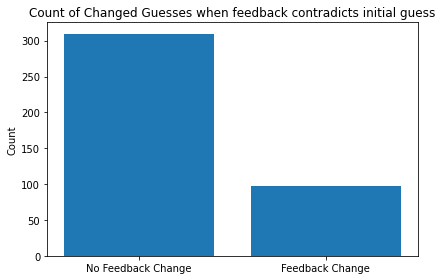

In [36]:
import matplotlib.pyplot as plt

# Count values
no_fb_change_same_fb = np.sum((new_df["feedback_change"] == 0) & (new_df["initial_guess"] != new_df["AI_guess"]))
fb_change_same_fb = np.sum((new_df["feedback_change"] == 1) & (new_df["initial_guess"] != new_df["AI_guess"]))

# Bar plot
labels = ["No Feedback Change", "Feedback Change"]
counts = [no_fb_change_same_fb, fb_change_same_fb]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.ylabel("Count")
plt.title("Count of Changed Guesses when feedback contradicts initial guess")
plt.tight_layout()
plt.show()


## ChatGPT proposed analysis : (A vérifier et completer !!)

In [37]:

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

df2 = new_df.copy()

In [38]:
# Whether initial and later guess are correct
df2['initial_correct'] = df2['initial_guess'] == df2['ground_truth']
df2['later_correct'] = df2['later_guess'] == df2['ground_truth']

# Change in confidence and accuracy
df2['confidence_change'] = df2['later_confidence'] - df2['initial_confidence']
df2['accuracy_change'] = df2['later_correct'].astype(int) - df2['initial_correct'].astype(int)

In [39]:
df2["participant_id"].iloc[0]

'R_8Do6YUFYQenUARY'

### 2x2 Mixed ANOVA

- Within: hum_AI (AI vs Human)
- Between: feedback_type (Text vs Audio)
- DVs: confidence_change, accuracy_change

In [40]:
# Aggregate per participant per condition (AI vs Human)
agg = df2.groupby(['participant_id', 'feedback_type', 'hum_AI']).agg({
    'confidence_change': 'mean',
    'accuracy_change': 'mean'
}).reset_index()


##### Run Mixed ANOVA (e.g., for confidence change):

In [41]:
import pingouin as pg

aov = pg.mixed_anova(data=agg, dv='confidence_change', 
                     within='hum_AI', between='feedback_type', 
                     subject='participant_id')
print(aov)


          Source          SS  DF1  DF2          MS         F     p-unc  \
0  feedback_type  138.345829    1   71  138.345829  1.291295  0.259630   
1         hum_AI  175.781096    1   71  175.781096  2.125774  0.149249   
2    Interaction   27.940056    1   71   27.940056  0.337888  0.562892   

        np2  eps  
0  0.017862  NaN  
1  0.029070  1.0  
2  0.004736  NaN  


## Paired t-tests Within Each Group (e.g., audio group AI vs Human)

In [42]:
audio_group = agg[agg['feedback_type'] == 'audio']
text_group = agg[agg['feedback_type'] == 'text']

# Paired t-tests within audio group
audio_ai = audio_group[audio_group['hum_AI'] == 'NH'].set_index('participant_id')
audio_human = audio_group[audio_group['hum_AI'] == 'H'].set_index('participant_id')

# Match on participant_id
common_ids = audio_ai.index.intersection(audio_human.index)
t_stat, p_val = stats.ttest_rel(audio_ai.loc[common_ids, 'confidence_change'],
                                 audio_human.loc[common_ids, 'confidence_change'])
print("Audio group: AI vs Human confidence change t-test: t_stat:", t_stat,", p_val :", p_val)

# same for text group
text_ai = text_group[text_group['hum_AI'] == 'NH'].set_index('participant_id')
text_human = text_group[text_group['hum_AI'] == 'H'].set_index('participant_id')
# Match on participant_id
common_ids = text_ai.index.intersection(text_human.index)
t_stat, p_val = stats.ttest_rel(text_ai.loc[common_ids, 'confidence_change'],
                                 text_human.loc[common_ids, 'confidence_change'])
print("Text group: AI vs Human confidence change t-test, t_stat:", t_stat,", p_val :", p_val)


Audio group: AI vs Human confidence change t-test: t_stat: 0.7812802454547029 , p_val : 0.4391259328832018
Text group: AI vs Human confidence change t-test, t_stat: 1.2789652215996343 , p_val : 0.21071431968291854


In [43]:
# same for accuracy_change
# Paired t-tests within audio group
audio_ai = audio_group[audio_group['hum_AI'] == 'NH'].set_index('participant_id')
audio_human = audio_group[audio_group['hum_AI'] == 'H'].set_index('participant_id')
# Match on participant_id
common_ids = audio_ai.index.intersection(audio_human.index)
t_stat, p_val = stats.ttest_rel(audio_ai.loc[common_ids, 'accuracy_change'],
                                 audio_human.loc[common_ids, 'accuracy_change'])
print("Audio group: AI vs Human accuracy change t-test, t_stat:", t_stat,", p_val :", p_val)
# same for text group
text_ai = text_group[text_group['hum_AI'] == 'NH'].set_index('participant_id')
text_human = text_group[text_group['hum_AI'] == 'H'].set_index('participant_id')
# Match on participant_id
common_ids = text_ai.index.intersection(text_human.index)
t_stat, p_val = stats.ttest_rel(text_ai.loc[common_ids, 'accuracy_change'],
                                 text_human.loc[common_ids, 'accuracy_change'])
print("Text group: AI vs Human accuracy change t-test, t_stat:", t_stat,", p_val :", p_val)

Audio group: AI vs Human accuracy change t-test, t_stat: 4.87754783707993 , p_val : 1.661693702889556e-05
Text group: AI vs Human accuracy change t-test, t_stat: 2.7524094128159016 , p_val : 0.009941586197226604


## Visualizations : Bar plots for confidence and accuracy change

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_17356\1112360397.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=agg, x='hum_AI', y='confidence_change', hue='feedback_type', ci=68)


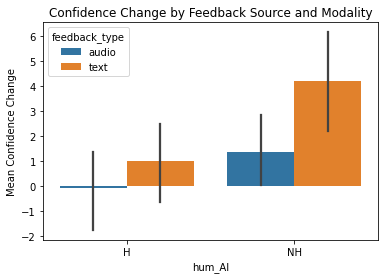

In [44]:

sns.barplot(data=agg, x='hum_AI', y='confidence_change', hue='feedback_type', ci=68)
plt.title("Confidence Change by Feedback Source and Modality")
plt.ylabel("Mean Confidence Change")
plt.show()


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_17356\141734533.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=agg, x='hum_AI', y='accuracy_change', hue='feedback_type', ci=68)


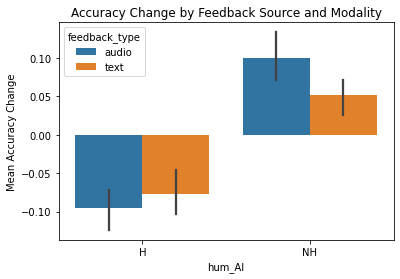

In [45]:
sns.barplot(data=agg, x='hum_AI', y='accuracy_change', hue='feedback_type', ci=68)
plt.title("Accuracy Change by Feedback Source and Modality")
plt.ylabel("Mean Accuracy Change")
plt.show()


## Exploratory Analyses

Correlation: confidence change vs feedback_influence

In [46]:
corr = df2['confidence_change'].corr(df2['feedback_influence'])
print("Correlation between confidence change and perceived feedback influence:", corr)


Correlation between confidence change and perceived feedback influence: -0.11106693368378617


Time-on-video vs change in confidence

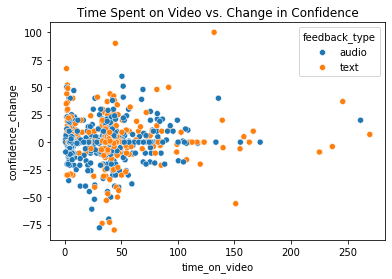

In [47]:
sns.scatterplot(data=df2, x='time_on_video', y='confidence_change', hue='feedback_type')
plt.title("Time Spent on Video vs. Change in Confidence")
plt.show()


## Thematic Analysis of Open-ended Responses

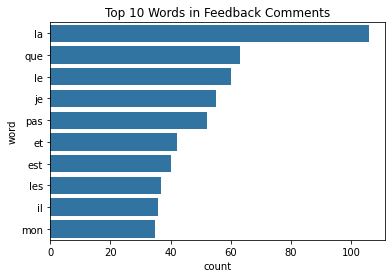

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df2['comments'].dropna())
words = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

top_words = pd.DataFrame({'word': words, 'count': counts}).sort_values(by='count', ascending=False)
sns.barplot(data=top_words.head(10), x='count', y='word')
plt.title("Top 10 Words in Feedback Comments")
plt.show()


## Participant-Level Summary Stats

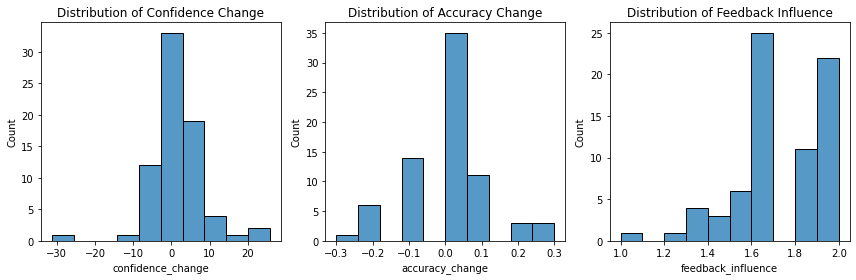

In [49]:
participant_summary = df2.groupby('participant_id').agg({
    'confidence_change': 'mean',
    'accuracy_change': 'mean',
    'feedback_influence': 'mean'
}).reset_index()

# plot the distribution of confidence, accuracy and feedback influence change
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(data=participant_summary, x='confidence_change', bins=10)
plt.title("Distribution of Confidence Change")
plt.subplot(1, 3, 2)
sns.histplot(data=participant_summary, x='accuracy_change', bins=10)
plt.title("Distribution of Accuracy Change")
plt.subplot(1, 3, 3)
sns.histplot(data=participant_summary, x='feedback_influence', bins=10)
plt.title("Distribution of Feedback Influence")
plt.tight_layout()
plt.show()





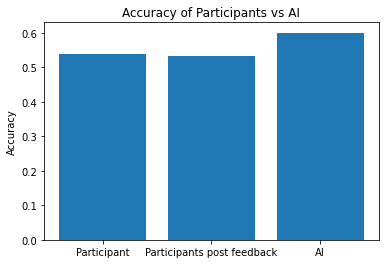

In [50]:
# participants accuracy vs ai guess accuracy
AI_acc = (np.array(list(gt_guess_dict.values())) == np.array(list(feedb_guess_dict.values()))).sum()/10
participant_accuracy = (df2['initial_guess'] == df2['ground_truth']).sum()/len(df2)
participant_accuracy_aft = (df2['later_guess'] == df2['ground_truth']).sum()/len(df2)



# plot histogram of the accuracy of the participants and AI on the y axis
plt.bar(['Participant','Participants post feedback', 'AI'],[participant_accuracy,participant_accuracy_aft, AI_acc])
plt.ylabel("Accuracy")
plt.title("Accuracy of Participants vs AI")
plt.show()



c:\users\utilisateur\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

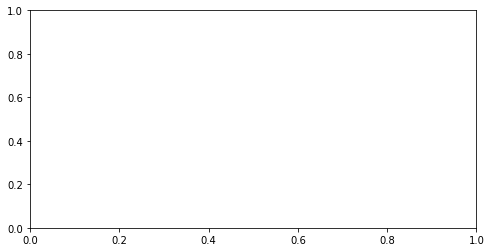

In [51]:
# plot the distribution of the accuracy of the participants
plt.figure(figsize=(8, 4))
plt.hist(df2['initial_guess'] == df2['ground_truth'], bins=10, alpha=0.5)
plt.title("Distribution of Participants Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.legend()
plt.show()



In [ ]:
df2.columns, participant_accuracy

(Index(['participant_id', 'video_number', 'feedback_type', 'hum_AI',
        'time_on_video', 'initial_guess', 'initial_confidence', 'later_guess',
        'later_confidence', 'feedback_influence', 'comments', 'feedback_change',
        'ground_truth', 'AI_guess', 'initial_correct', 'later_correct',
        'confidence_change', 'accuracy_change', 'AI_guess_correct',
        'participant_accuracy'],
       dtype='object'),
 np.float64(0.5375))

# Trucs de Lio qui sont là depuis le début, pas sûr que c'est utile ...

In [ ]:
# Exemple (à adapter):
# df = df.dropna(subset=["participant_id", "accuracy_pre", "accuracy_post", "confidence_pre", "confidence_post"])

# Renommer si besoin
# df.rename(columns={
#     "old_colname_1": "accuracy_pre",
#     "old_colname_2": "accuracy_post",
#     ...
# }, inplace=True)

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 6 to 64
Columns: 162 entries, startdate to feedback_type
dtypes: int64(1), object(161)
memory usage: 50.9+ KB


,finished
count,40.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


## 2. Création des variables d'intérêt

Ici, on crée par exemple la différence de précision et de confiance (post - pré) pour chaque participant.


In [ ]:
# Supposez que df contient déjà accuracy_pre, accuracy_post, confidence_pre, confidence_post
df["accuracy_diff"] = df["accuracy_post"] - df["accuracy_pre"]
df["confidence_diff"] = df["confidence_post"] - df["confidence_pre"]

df.head()


## 3. Statistiques descriptives


In [ ]:
# Statistiques descriptives globales
print(df[["accuracy_pre", "accuracy_post", "confidence_pre", "confidence_post"]].describe())

# Par groupe de Feedback Modality (Audio vs. Texte) et Feedback Source (Humain vs. IA)
group_stats = df.groupby(["feedback_modality", "feedback_source"])[["accuracy_pre","accuracy_post","confidence_pre","confidence_post"]].describe()
group_stats


NameError: name 'df' is not defined

### Visualisation (optionnel)

On peut faire quelques graphiques (histogrammes, boxplots) pour visualiser la distribution des variables et tester la normalité.


NameError: name 'df' is not defined

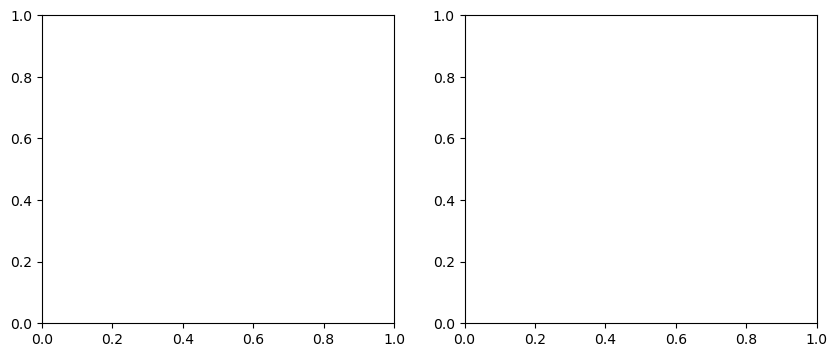

In [ ]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df["accuracy_diff"].dropna(), bins=10)
axes[0].set_title("Distribution accuracy_diff")

axes[1].hist(df["confidence_diff"].dropna(), bins=10)
axes[1].set_title("Distribution confidence_diff")

plt.show()


## 4. ANOVA mixte 2×2

Nous avons :
- Facteur intra-sujets : Feedback Source (Humain vs. IA)
- Facteur inter-sujets : Feedback Modality (Audio vs. Texte)
- Variable dépendante : par exemple *accuracy_diff* (et on fera la même chose pour *confidence_diff*).

### Option A : Avec Pingouin (Mixed ANOVA)


In [ ]:
# Exemple si vous utilisez pingouin.
# 1. Il faut avoir un format "long" :
#    Chaque participant apparaît dans 2 lignes (Humain vs. IA) pour la mesure within-subject
#    feedback_modality reste constant pour le participant.

# Démélangez ou "melt" si nécessaire. Supposez que vous avez une variable 'feedback_source' 
# déjà incrémentée sur chaque ligne. 
# Sinon, vous devez réorganiser le DataFrame (pivot_longer, etc.).

# Pour la démonstration seulement (pseudo-code):
"""
df_long = pd.melt(
    df, 
    id_vars=["participant_id", "feedback_modality"], 
    value_vars=["accuracy_diff_humain","accuracy_diff_IA"], 
    var_name="feedback_source", 
    value_name="accuracy_diff"
)
# feedback_source pourra être "humain" ou "IA" selon la colonne d'origine
# Ensuite:
anova_results = pg.mixed_anova(dv="accuracy_diff",
                               within="feedback_source",
                               between="feedback_modality",
                               subject="participant_id",
                               data=df_long)
print(anova_results)
"""


### Option B : Avec Statsmodels (MixedLM)

Il faut un modèle linéaire mixte, avec participant_id comme effet aléatoire (group).  
Vous pouvez également modéliser l’interaction.

*(La mise en forme dépend de la manière dont vos données sont structurées.)*


In [ ]:
# Exemple très simplifié (vous devrez sans doute adapter le code et le format):
# Notons que dans Statsmodels, il faut coder feedback_source en 0/1 ou en variable catégorielle.

# Supposez que feedback_source (Humain vs. IA) et feedback_modality (Audio vs. Texte) 
# sont des colonnes du DF 'df_long' (chaque ligne = 1 participant × 1 condition).
# On va créer un modèle mixte:
"""
model = smf.mixedlm("accuracy_diff ~ feedback_source * feedback_modality", 
                    df_long, 
                    groups=df_long["participant_id"])
fit = model.fit()
print(fit.summary())
"""


'\nmodel = smf.mixedlm("accuracy_diff ~ feedback_source * feedback_modality", \n                    df_long, \n                    groups=df_long["participant_id"])\nfit = model.fit()\nprint(fit.summary())\n'

## 5. Comparaisons t-tests appariés (avant/après)


In [ ]:
# Exemple : Comparer la confiance avant/après pour le groupe "audio"
audio_df = df[df["feedback_modality"] == "audio"].dropna(subset=["confidence_pre","confidence_post"])
t_stat, p_val = stats.ttest_rel(audio_df["confidence_pre"], audio_df["confidence_post"])
print(f"Groupe Audio - t={t_stat:.2f}, p={p_val:.4f}")

# Faire la même chose pour d'autres sous-groupes ou pour la variable accuracy_pre vs accuracy_post


NameError: name 'df' is not defined

## 6. Analyse qualitative des réponses ouvertes

Vous pouvez faire un premier aperçu en affichant les réponses, puis procéder à un codage manuel ou semi-automatisé.


In [ ]:
# Exemple : si la question ouverte est dans une colonne "open_response"
# On peut consulter les premières réponses
if "open_response" in df.columns:
    for idx, resp in enumerate(df["open_response"].dropna().head(10)):
        print(f"Participant {idx}: {resp}\n")


*(Ensuite, l’analyse approfondie peut se faire hors-ligne ou via un script dédié, 
avec par ex. des techniques de text-mining ou un codage thématique manuel.)*

---

## 7. Conclusion / Interprétation

- Interprétez les résultats des analyses (ANOVA, t-tests, etc.).
- Discutez des effets principaux, interactions et éventuels effets post hoc.
- Intégrez les thèmes émergents de l’analyse qualitative.

---
